In [1]:
# Codigo escrito por Mauricio Orozco Sierra
import os
import zipfile
import numpy as np
import pandas as pd
import librosa
import glob 
import librosa.display
import random
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import tensorflow as tf
import winsound
import sounddevice as sd
import shutil

In [2]:
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder # Se usa para hacerle encode a los valores de salida, y
from keras.utils import np_utils
from natsort import os_sorted
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.utils.np_utils import to_categorical
from tensorflow.keras import regularizers
from scipy.io.wavfile import write

In [3]:
def extract_features(files, path):
    
    file_name = os.path.join(os.path.abspath(path)+'/'+ files.file)
    # Se usa la siguiente linea para confirmar que esta iterando por cada uno, pero se pone como comentario para
    # reducir el bloat.
    # print(file_name)
    X, sample_rate = librosa.load(file_name, res_type = 'kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    stft = np.abs(librosa.stft(X))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y = X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    label = files.isMe

    return mfccs, chroma, mel, contrast, tonnetz, label

In [4]:
path_train = r"C:\Users\mauro\Desktop\voz\cv-valid-train";
# Se usa un os_sorting para sortear los datos como lo hace el explorador de windows, de lo contrario
# empieza a sortear de manera 0, 1, 10, 100, 101... y se vuelve dificil poner el tag de 'isMe' correctamente despues
filelist = os_sorted(os.listdir(path_train))
df_voice_train = pd.DataFrame(filelist)
df_voice_train = df_voice_train.rename(columns = {0:'file'})
df_voice_train['isMe'] = 0

In [5]:
path_test = r"C:\Users\mauro\Desktop\voz\cv-valid-test";
filelist = os_sorted(os.listdir(path_test))
df_voice_test = pd.DataFrame(filelist)
df_voice_test = df_voice_test.rename(columns = {0:'file'})
df_voice_test['isMe'] = 0

In [6]:
df_voice_train.loc[401:470, 'isMe'] = 1
df_voice_test.loc[75:104, 'isMe'] = 1

In [7]:
# Se hace scramble a todos los datos. Probando con el DataFrame sin hacer esto, la validacion empezaba a tener un loss
# enorme y un accuracy muy bajo. Se reinicia el index para que los datos queden ordenados de manera correcta.

df_voice_train = df_voice_train.sample(frac=1).reset_index()

In [8]:
df_voice_test = df_voice_test.sample(frac=1).reset_index()

In [9]:
df_voice_test

,index,file,isMe
0,29,sample_test_0029.wav,0
1,20,sample_test_0020.wav,0
2,24,sample_test_0024.wav,0
3,81,sample_test_0081.wav,1
4,33,sample_test_0033.wav,0
...,...,...,...
100,0,sample_test_000.wav,0
101,103,sample_test_00103.wav,1
102,47,sample_test_0047.wav,0
103,98,sample_test_0098.wav,1


In [10]:
# Confirmar que los archivos de audio con valor 'isMe' = 1 son efectivamente mi propia voz.
# winsound.PlaySound(os.path.join(os.path.abspath(r"C:\Users\mauro\Desktop\voz\cv-valid-test")+'/'+ df_voice_test['file'][103]), winsound.SND_FILENAME)

In [10]:
features_label_train = df_voice_train.apply(lambda x: extract_features(x, path_train), axis = 1)

C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=629
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=769
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=654
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=736
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=918
  return f(*args, **kwargs)


In [11]:
features_label_test = df_voice_test.apply(lambda x: extract_features(x, path_test), axis = 1)

C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=654
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=860
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=753
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=960
  return f(*args, **kwargs)
C:\Users\mauro\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=827
  return f(*args, **kwargs)


In [12]:
features_label_test

0      ([-289.80035, 76.58584, 17.222445, 16.689222, ...
1      ([-403.5547, 42.665108, -4.97962, 9.187287, -2...
2      ([-274.82874, 35.618134, -27.117113, 18.468235...
3      ([-276.09772, 33.030148, 11.652072, 17.18662, ...
4      ([-305.77362, 75.11698, 27.02643, 24.857107, 1...
                             ...                        
100    ([-319.2235, 94.4155, 0.85432684, -0.17799442,...
101    ([-254.56262, 49.292755, 14.356966, 10.4598, -...
102    ([-373.8548, 44.423397, -10.275534, 21.140705,...
103    ([-294.92215, 35.16021, 14.492093, 14.835854, ...
104    ([-255.59514, 63.063564, 0.07069478, 10.995437...
Length: 105, dtype: object

In [15]:
#features_label_train

In [13]:
def concatenate(features_label):
    features = []
    for i in range(0, len(features_label)):
        features.append(np.concatenate((features_label[i][0], features_label[i][1], features_label[i][2], features_label[i][3],
                                        features_label[i][4]), axis=0))
    return features

In [14]:
features_train = concatenate(features_label_train)
features_test = concatenate(features_label_test)

In [16]:
# Visualizacion para confirmar que features_test esta compuesto de arreglos concatenados, contrario a features_label_test.
# Lo mismo aplica para features_train
features_test

[array([-2.89800354e+02,  7.65858383e+01,  1.72224445e+01,  1.66892223e+01,
        -5.31174374e+00,  8.73437881e+00,  4.94564342e+00, -1.90017414e+01,
        -1.28275871e+01, -3.07244515e+00, -7.29656792e+00,  6.40795088e+00,
        -5.76298809e+00, -5.22704601e+00,  6.56422091e+00, -4.02691221e+00,
        -1.19306145e+01,  1.52922046e+00, -5.66355276e+00, -3.88342953e+00,
         2.07439497e-01, -7.98559475e+00, -2.38536596e+00, -7.79912829e-01,
        -6.18623638e+00, -2.29282522e+00, -2.81434059e+00, -7.08857626e-02,
        -5.45850098e-01, -1.23683834e+00, -1.19110204e-01, -6.27085447e-01,
        -2.69380784e+00, -2.11720586e+00, -3.41916895e+00, -1.81556320e+00,
        -2.36294246e+00, -2.05433655e+00, -7.18090594e-01, -1.16603231e+00,
         7.23555446e-01,  6.50123954e-01,  5.75071990e-01,  6.04229510e-01,
         5.99559724e-01,  5.73045373e-01,  5.17490208e-01,  4.87954319e-01,
         4.74977404e-01,  5.11277199e-01,  6.14814937e-01,  6.98348939e-01,
         2.1

In [16]:
def extract_isMe(df):
    speaker = []
    for i in range (0, len(df)):
        speaker.append(df['isMe'][i])
    return speaker

In [17]:
speaker_train = extract_isMe(df_voice_train)
speaker_test = extract_isMe(df_voice_test)

In [18]:
# Visualizacion para confirmar que si hay tanto archivos que pertenecen a mi voz como archivos que no.
speaker_train

[0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


In [19]:
x_train = np.array(features_train)
x_test = np.array(features_test)

In [20]:
y_train = np.array(speaker_train)
y_test = np.array(speaker_test)

In [21]:
x_train.shape

(470, 193)

In [22]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [23]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.

In [24]:
ss = StandardScaler()
X_train = ss.fit_transform(x_train)
X_test = ss.fit_transform(x_test)
np.mean(x_train)

-0.1741068736123703

In [25]:
X_test[1]

array([-0.47855323, -0.23361428, -1.0854249 , -0.52436593, -0.58030137,
       -0.0933548 ,  0.80321902, -0.51654128, -1.00317748, -0.59907734,
       -0.44373483,  0.03666858,  1.04243745, -0.25718825, -0.7279384 ,
        1.59570698,  0.81139143,  0.30967441,  0.69004801, -0.65902984,
        0.53815343,  0.06778171,  0.45947558,  1.13208269,  0.7727352 ,
        0.36646358,  0.90866119,  0.8834035 ,  1.30099187,  0.52540944,
       -0.68006983,  0.49575173,  0.33463799, -0.183828  ,  0.86522607,
       -0.05625682, -0.28396115,  0.67499889,  0.00811333, -0.43335844,
       -1.28293776, -1.53744259, -1.24660187, -1.08728027, -1.0319969 ,
       -1.04696845, -1.19207823, -1.27178143, -1.33363574, -1.35671996,
       -0.92749325, -0.93317917, -0.13749485, -0.16642344, -0.36775791,
       -0.58661315, -0.63589457, -0.47944058, -0.43829798, -0.02031221,
        0.06218732, -0.46800438, -0.44580086, -0.36848378, -0.23337297,
       -0.14077254, -0.48517437, -0.44790618,  0.03601362,  2.30

In [26]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

In [27]:
# Se crea el modelo, con una entrada ligeramente menor que la forma de x_train, y una salida de solo 2 neuronas, 
# debido a que la salida solo puede ser 1 o 0
model=Sequential()
model.add( Dense(4, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
#model.add( Dense(3, activation='relu'))
model.add( Dense(output_dim, activation='softmax'))

In [28]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
history=model.fit(X_train, y_train, validation_split=0.3, epochs=100)

Epoch 1/100
11/11 [==============================] - 2s 81ms/step - loss: 0.6424 - accuracy: 0.6930 - val_loss: 0.4795 - val_accuracy: 0.7660
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4367 - accuracy: 0.8085 - val_loss: 0.3473 - val_accuracy: 0.8582
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3153 - accuracy: 0.8875 - val_loss: 0.2842 - val_accuracy: 0.9007
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2769 - accuracy: 0.9058 - val_loss: 0.2435 - val_accuracy: 0.9504
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2406 - accuracy: 0.9271 - val_loss: 0.2174 - val_accuracy: 0.9574
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2159 - accuracy: 0.9483 - val_loss: 0.1986 - val_accuracy: 0.9645
Epoch 7/100
11/11 [==============================] - 0s 13ms/step - loss: 0.1969 - accuracy: 0.9726 - val_loss: 0.1856 - val_accuracy: 0.9574
Epoch 

11/11 [==============================] - 0s 10ms/step - loss: 0.0558 - accuracy: 0.9818 - val_loss: 0.0744 - val_accuracy: 0.9858
Epoch 59/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0478 - accuracy: 0.9909 - val_loss: 0.0745 - val_accuracy: 0.9858
Epoch 60/100
11/11 [==============================] - 0s 12ms/step - loss: 0.0562 - accuracy: 0.9878 - val_loss: 0.0747 - val_accuracy: 0.9858
Epoch 61/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0560 - accuracy: 0.9878 - val_loss: 0.0749 - val_accuracy: 0.9858
Epoch 62/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0474 - accuracy: 0.9909 - val_loss: 0.0746 - val_accuracy: 0.9858
Epoch 63/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0445 - accuracy: 0.9939 - val_loss: 0.0744 - val_accuracy: 0.9858
Epoch 64/100
11/11 [==============================] - 0s 11ms/step - loss: 0.0505 - accuracy: 0.9878 - val_loss: 0.0724 - val_accuracy: 0.9858
Epoch 65/100

In [30]:
predict_x = model.predict(X_test) 
classes_x = np.argmax(predict_x,axis=1)

4/4 [==============================] - 0s 5ms/step


In [48]:
classes_x

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], dtype=int64)

In [46]:
predict_x

array([[9.5467991e-01, 4.5320131e-02],
       [9.9972898e-01, 2.7105588e-04],
       [9.9999857e-01, 1.4066402e-06],
       [9.9997354e-01, 2.6419573e-05],
       [1.1963710e-03, 9.9880362e-01],
       [9.9863774e-01, 1.3623027e-03],
       [9.9998844e-01, 1.1584463e-05],
       [9.9997675e-01, 2.3192233e-05],
       [9.9999607e-01, 3.8913336e-06],
       [9.9999774e-01, 2.2201684e-06],
       [9.9993348e-01, 6.6524728e-05],
       [7.6699871e-01, 2.3300128e-01],
       [2.1772538e-04, 9.9978226e-01],
       [9.8459561e-05, 9.9990153e-01],
       [7.6699871e-01, 2.3300128e-01],
       [9.9827302e-01, 1.7270114e-03],
       [9.9999833e-01, 1.6633712e-06],
       [7.7580367e-03, 9.9224198e-01],
       [9.9999857e-01, 1.3869073e-06],
       [9.9970067e-01, 2.9934937e-04],
       [7.6699871e-01, 2.3300128e-01],
       [9.9999905e-01, 1.0067949e-06],
       [9.9999893e-01, 1.0139075e-06],
       [9.9991453e-01, 8.5518484e-05],
       [9.9997151e-01, 2.8439996e-05],
       [9.9999428e-01, 5.

In [31]:
df_voice_test['predicts'] = classes_x

In [32]:
# Se muestra el DataFrame de testeo con la nueva columna de predicciones
df_voice_test

,index,file,isMe,predicts
0,29,sample_test_0029.wav,0,0
1,20,sample_test_0020.wav,0,0
2,24,sample_test_0024.wav,0,0
3,81,sample_test_0081.wav,1,1
4,33,sample_test_0033.wav,0,0
...,...,...,...,...
100,0,sample_test_000.wav,0,0
101,103,sample_test_00103.wav,1,1
102,47,sample_test_0047.wav,0,0
103,98,sample_test_0098.wav,1,1


In [33]:
# Mostrar todos los datos del test que luego de poner las predicciones en el DataFrame son incorrectas usando como base el 'isMe'
df_voice_test[df_voice_test['isMe'] != df_voice_test['predicts']]

,index,file,isMe,predicts


In [34]:
df_print = df_voice_test[df_voice_test['isMe'] != df_voice_test['predicts']]

In [35]:
# Mostrar la presicion.
1-round(len(df_voice_test[df_voice_test['isMe'] != df_voice_test['predicts']])/len(df_voice_test),3)

1.0

In [36]:
def res_vis(history):
  epochs = [i for i in range(100)]
  fig, ax = plt.subplots(1,2)
  train_acc = history.history["accuracy"]
  train_loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]
  fig.set_size_inches(16, 9)

  ax[0].plot(epochs, train_acc, "go-", label =" Entrenamiento accuracy")
  ax[0].plot(epochs, val_acc, "ro-", label= "Validacion accuracy")
  ax[0].set_title("Entrenamiento & validación accuracy")
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs, train_loss, "go-", label =" Entrenamiento Loss")
  ax[1].plot(epochs, val_loss, "ro-", label= "Validacion Loss")
  ax[1].set_title("Entrenamiento & validación Loss")
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Loss")

  plt.show()

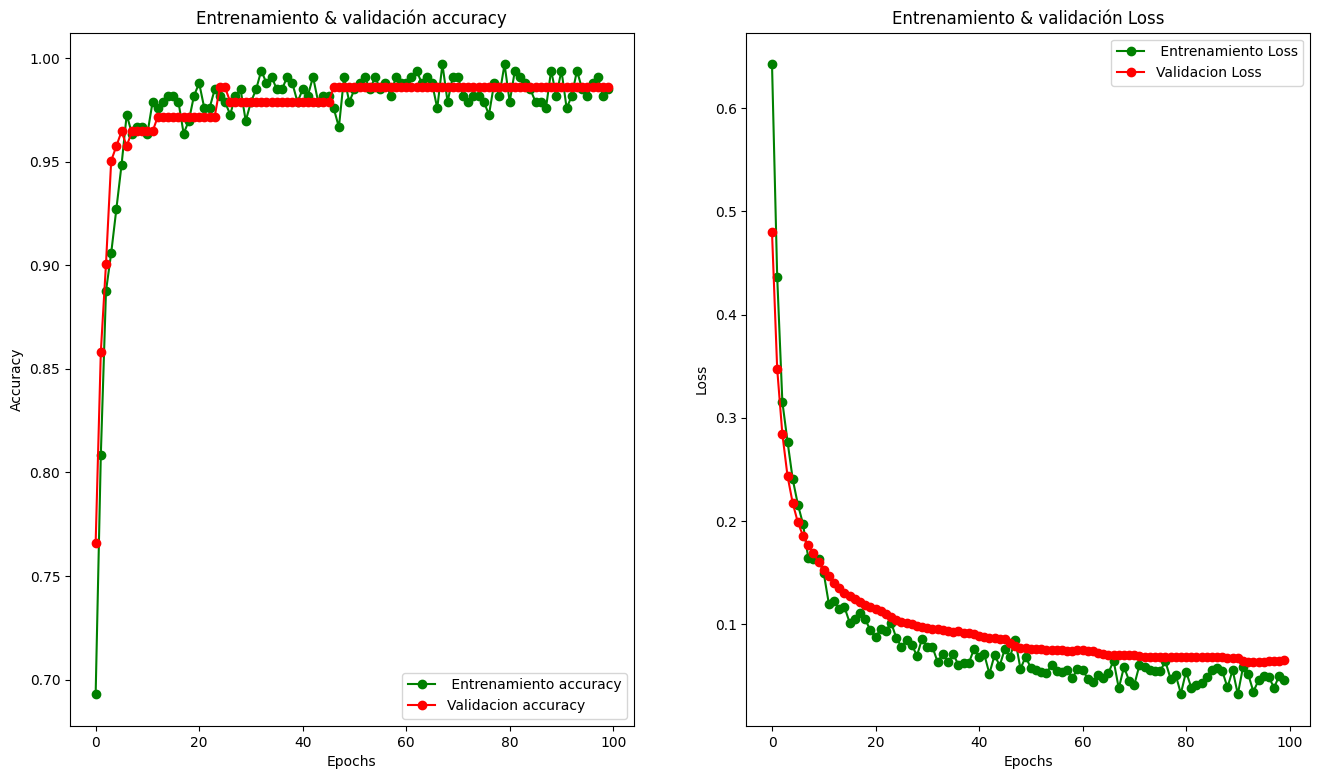

In [37]:
res_vis(history)

In [60]:
if len(df_print) == 0:
    print("Se predijo los 30 datos de prueba correctamente.")
else:
    print("Hay " + str(len(df_print)) + " de 30 datos que no se predijeron correctamente.")

Hay 2 de 30 datos que no se predijeron correctamente.


In [41]:
# Cambiar el nombre de todos los archivos de un folder
import os
import glob
# files
lst = glob.glob("*.wav")
i = 400
for file in lst:
    new_name = "sample_train_00" + str(i) + ".wav"
    os.rename(file, new_name)
    i += 1

In [42]:
# Convertir todos los archivos en un folder de .mp3 a .wav
import os
import glob
# files                                                                         
lst = glob.glob("*.mp3")
for file in lst:
    os.system(f"""ffmpeg -i {file} -acodec pcm_u8 -ar 22050 {file[:-4]}.wav""")         